<a href="https://colab.research.google.com/github/mafaldasalomao/pavic_treinamento_ml/blob/main/PAVIC_ML_06_Rede_Neural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sumário

[Funções de Ativação](#Funções-de-Ativação)

[Funções Auxiliares](#Funções-Auxiliares)

[Funções de Custo](#Funções-de-Custo)

[Inicialização de Pesos](#Inicialização-de-Pesos)

[Regularização](#Regularização)

[Learning Rate Decay](#Learning-Rate-Decay)

[Batch Normalization](#Batch-Normalization)

[Batch Generator](#Batch-Generator)

[Implementação](#Implementação)

[Testes da Implementação](#Testes-da-Implementação)

- [Exemplos do Notebook da Intuição](#Exemplos-do-Notebook-da-Intuição)

- [Regressão](#Regressão)
    - [Regressão Linear Simples](#Regressão-Linear-Simples---Exemplo-do-Perceptron)
    - [Regressão Linear Multivariada](#Regressão-Linear-Multivariada---Exerc%C3%ADcio-de-Regressão-do-Perceptron)
    - [Regressão Quadrática](#Regressão-Quadrática)
    - [Regressão Cúbica](#Regressão-Cúbica)
    - [Regressão Logarítimica](#Regressão-Logar%C3%ADtimica)
    - [Regressão Exponencial](#Regressão-Exponencial)

- [Classificação Binária](#Classificação-Binária)
    - [Porta AND/OR](#Porta-AND/OR)
    - [Porta XOR](#Porta-XOR)
    - [2 Clusters](#2-Clusters)
    - [4 Clusters](#4-Clusters)
    - [Círculos](#C%C3%ADrculos)
    - [Moons](#Moons)
    - [Espiral](#Espiral)
    
- [Classificação Multiclasse](#Classificação-Multiclasse)
    - [3 Clusters Multiclasse](#3-Clusters-Multiclasse)
    - [4 Clusters Multiclasse](#4-Clusters-Multiclasse)
    - [Espiral - 5 Classes](#Espiral---5-Classes)
    - [Make Classification - 4 Classes](#Make-Classification---4-Classes)
    - [Iris Dataset](#Iris-Dataset)

[Referências](#Referências)

# Imports and Configurações

In [ ]:
pip uninstall requests

Found existing installation: requests 2.27.1
Uninstalling requests-2.27.1:
  Would remove:
    /usr/local/lib/python3.9/dist-packages/requests-2.27.1.dist-info/*
    /usr/local/lib/python3.9/dist-packages/requests/*
Proceed (Y/n)? y
  Successfully uninstalled requests-2.27.1


In [ ]:
pip install requests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 2.2 MB/s eta 0:00:00


In [29]:
!pip install utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
import numpy as np
import _pickle as pkl
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.datasets import make_blobs, make_circles, make_moons, make_classification

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from utils_ex import plot
from utils_ex.samples_generator import make_spiral, make_square, make_cubic, make_exp, make_log10

%matplotlib inline

# Funções de Ativação

In [2]:
def linear(x, derivative=False):
    return np.ones_like(x) if derivative else x

def sigmoid(x, derivative=False):
    if derivative:
        y = sigmoid(x)
        return y*(1 - y)
    return 1.0/(1.0 + np.exp(-x))

def tanh(x, derivative=False):
    if derivative:
        y = tanh(x)
        return 1 - y**2
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0, 1)
    return np.maximum(0, x)

def leaky_relu(x, derivative=False):
    alpha = 0.1
    if derivative:
        return np.where(x <= 0, alpha, 1)
    return np.where(x <= 0, alpha*x, x)

def elu(x, derivative=False):
    alpha = 1.0
    if derivative:
        y = elu(x)
        return np.where(x <= 0, y + alpha, 1)
    return np.where(x <= 0, alpha*(np.exp(x) - 1), x)

# Funções Auxiliares

In [3]:
def softmax(x, y_oh=None, derivative=False):
    if derivative:
        y_pred = softmax(x)
        k = np.nonzero(y_pred * y_oh)
        pk = y_pred[k]
        y_pred[k] = pk * (1.0 - pk)
        return y_pred
    exp = np.exp(x)
    return exp / np.sum(exp, axis=1, keepdims=True)

# Funções de Custo

###### Para Regressão

In [4]:
#A ser implementado
def mae(y, y_pred, derivative=False):
  if derivative:
    return np.where(y_pred > y, 1, -1)/ y.shape[0]
  return np.mean(np.abs(y - y_pred))

In [5]:
#A ser implementado
def mse(y, y_pred, derivative=False):
  if derivative:
    return -(y - y_pred) / y.shape[0]
  return 0.5 * np.mean((y - y_pred)**2)

###### Para Classificação Binária

In [110]:
def binary_cross_entropy(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred) / (y_pred * (1-y_pred) * y.shape[0])
    return -np.mean(y*np.log(y_pred) + (1-y)*np.log(1-y_pred))

#Assim como no caso da Sigmoid e Neg.... Precisamos agora calcular a softmax para esa funçao
def sigmoid_cross_entropy(y, y_pred, derivative=False):
    y_sigmoid = sigmoid(y_pred)
    if derivative:
        return -(y - y_sigmoid) / y.shape[0]
    return -np.mean(y*np.log(y_sigmoid) + (1-y)*np.log(1-y_sigmoid))

###### Para Classificação Multiclasse

In [7]:
def neg_log_likelihood(y_oh, y_pred, derivative=False):
    k = np.nonzero(y_pred * y_oh)
    pk = y_pred[k]
    if derivative:
        y_pred[k] = (-1.0 / pk)
        return y_pred
    return np.mean(-np.log(pk))

def softmax_neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_softmax = softmax(y_pred)
    if derivative:
        return -(y_oh - y_softmax) / y_oh.shape[0]    
    return neg_log_likelihood(y_oh, y_softmax)

# Inicialização de Pesos

In [ ]:
def zeros(rows, cols): # in, out
  return np.zeros((rows, cols))
def ones(rows, cols):
  return np.ones((rows, cols))
def random_normal(rows, cols):
  return np.random.randn(rows, cols)
def random_uniform(rows, cols):
  return np.random.rand((rows, cols))
def glorot_normal(rows, cols):
  std_dev = np.sqrt(2.0 / (rows + cols))
  return std_dev * np.random.randn(rows, cols)
def glorot_uniform(rows, cols):
  limit = np.sqrt(6.0 / (rows + cols))
  return 2 * limit * np.random.randn(rows, cols) - limit

# Regularização

# Batch Generator

# Learning Rate Decay

# Batch Normalization 

# Implementação 

In [8]:
class Layer():
  #cada camada possui dimensao de entrada, saída e camada de ativaçao
  def __init__(self, input_dim, output_dim, weights_initializer=random_normal, bias_initializer=ones, activation=linear):
    self.input = None
    #sem implementar os metodos de peso
    #self.weights = np.random.randn(output_dim, input_dim)
    #self.biases = np.random.randn(1, output_dim)
    #quando implementar os pesos
    self.weights = weights_initializer(output_dim, input_dim)
    self.biases = bias_initializer(1, output_dim)
    self.activation = activation

    #para guardar as saídas das camadas
    self._activ_inp, self._activ_out = None, None
    #guardar as derivadas
    self._dweights, self._dbiases = None, None



class NeuralNetwork():
  def __init__(self, cost_func=mse, learning_rate=1e-3):
    self.layers = []
    self.cost_func = cost_func
    self.learning_rate = learning_rate

  def fit(self, x_train, y_train, epochs=100, verbose=10):
    for epoch in range(epochs+1):
      #vamos calcular o retorno da nossa rede
      y_pred = self.__feedforward(x_train)
      #chamaremos nosso back prop pra atulizar os pesos
      y_pred = self.__backprop(y_train, y_pred)

      if epoch % verbose == 0:
        loss_train = self.cost_func(y_train, self.predict(x_train)) #passamos o pred pois os pesso ja foram atualizados.... o y_pred nao
        print("Epoch: {0:=4}/{1} loss_train: {2:.8f}".format(epoch, epochs, loss_train))

  def predict(self, x):
    return self.__feedforward(x)



  def __feedforward(self, x): #__ torna dificil o acesso o acesso a funcao
    self.layers[0].input = x # a primeira entrada são nossos dados
    for current_layer, next_layer in zip(self.layers, self.layers[1:] + [Layer(0, 0)]): # vamos adicionar todas camadas no current_layer, e a partir da segunda no next_layers + [] para ter msm tamanho
      y = np.dot(current_layer.input, current_layer.weights.T) + current_layer.biases # vamos calcular normalmente o neuronio
      current_layer._activ_inp = y # vamos guardar a saída
      current_layer._activ_out = next_layer.input =  current_layer.activation(y) # aplicamos a ativação na saída , que tbm é a entrada da proxima camada
    #precisamos retornar a saída da rede
    return self.layers[-1]._activ_out

  def __backprop(self, y, y_pred):
    last_delta = self.cost_func(y, y_pred, derivative=True) # vamso calcular o custo
    #vamos calcular a derivada das camadas
    for layer in reversed(self.layers):
      dactivation = layer.activation(layer._activ_inp, derivative=True) * last_delta #derivada da func actv com a entrada de cada camada
      last_delta = np.dot(dactivation, layer.weights)
      layer._dweights = np.dot(dactivation.T, layer.input)
      layer._dbiases = 1.0 * dactivation.sum(axis=0, keepdims=True)
    #agora vamos atulizar nossos pesos
    for layer in reversed(self.layers):
      layer.weights = layer.weights - self.learning_rate * layer._dweights
      layer.biases = layer.biases - self.learning_rate * layer._dbiases

## Exemplos do Notebook da Intuição

### Exemplo 1

In [ ]:
x = np.array([[0.05, 0.10]])
y = np.array([[0.01, 0.99]])

w1 = np.array([[0.15, 0.20], [0.25, 0.30]])
b1 = np.array([[0.35]]) 
w2 = np.array([[0.40, 0.45], [0.50, 0.55]])
b2 = np.array([[0.60]])

# insira sua rede aqui!
input_dim, output_dim = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=0.5)
nn.layers.append(Layer(input_dim, output_dim=2, activation=sigmoid))
nn.layers.append(Layer(2, output_dim=output_dim, activation=sigmoid))

#como queremos testar o msm experimento feito anteriormente precisamos inicializar os pesos igualmente
nn.layers[0].weights = w1
nn.layers[0].biases = b1
nn.layers[1].weights = w2
nn.layers[1].biases = b2

#vamos treinar a rede
nn.fit(x, y, epochs=0, verbose = 1)

for layer in nn.layers:
  print(layer.weights)

Epoch:    0/0 loss_train: 0.14023572
[[0.14978072 0.19956143]
 [0.24975114 0.29950229]]
[[0.35891648 0.40866619]
 [0.51130127 0.56137012]]


### Exemplo 2

In [9]:
x = np.array([[0.1, 0.2, 0.7]])
y = np.array([[1, 0, 0]])
D_in, D_out = x.shape[1], y.shape[1]

w1 = np.array([[0.1, 0.2, 0.3], [0.3, 0.2, 0.7], [0.4, 0.3, 0.9]])
b1 = np.ones((1,3))
w2 = np.array([[0.2, 0.3, 0.5], [0.3, 0.5, 0.7], [0.6, 0.4, 0.8]])
b2 = np.ones((1,3))
w3 = np.array([[0.1, 0.4, 0.8], [0.3, 0.7, 0.2], [0.5, 0.2, 0.9]])
b3 = np.ones((1,3))

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=0.01)
nn.layers.append(Layer(input_dim= D_in, output_dim=3, activation=relu))
nn.layers.append(Layer(input_dim= 3, output_dim=3, activation=sigmoid))
nn.layers.append(Layer(input_dim= 3, output_dim=D_out, activation=linear))

for i, w, b in zip(range(3), [w1, w2, w3], [b1, b2, b3]):
  nn.layers[i].weights = w
  nn.layers[i].biases = b

nn.fit(x, y, epochs=300, verbose=30)

for layer in nn.layers:
  print(layer.weights)

Epoch:    0/300 loss_train: 1.14054966
Epoch:   30/300 loss_train: 0.59630022
Epoch:   60/300 loss_train: 0.36031189
Epoch:   90/300 loss_train: 0.24668884
Epoch:  120/300 loss_train: 0.18386202
Epoch:  150/300 loss_train: 0.14510157
Epoch:  180/300 loss_train: 0.11918285
Epoch:  210/300 loss_train: 0.10078511
Epoch:  240/300 loss_train: 0.08712037
Epoch:  270/300 loss_train: 0.07660623
Epoch:  300/300 loss_train: 0.06828531
[[0.10083595 0.2016719  0.30585165]
 [0.30086971 0.20173942 0.70608796]
 [0.40145052 0.30290104 0.91015363]]
[[0.20544723 0.30673159 0.50749567]
 [0.30994562 0.5123005  0.71366784]
 [0.61065514 0.41317913 0.81464085]]
[[ 0.66465527  0.98758148  1.39393956]
 [ 0.05020341  0.44006253 -0.06274803]
 [ 0.18514132 -0.12764401  0.56880846]]


## Gradient Checking

## Regressão

### Regressão Linear Simples - Exemplo do Perceptron

(100, 2)
(100, 1) (100, 1)


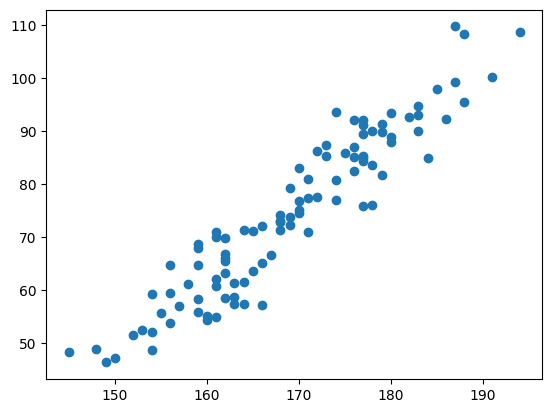

In [12]:
data = np.loadtxt('medidas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,0].reshape(-1,1), data[:,1].reshape(-1,1)
print(x.shape, y.shape)
plt.scatter(x, y)

-1.0 0.9999999999999991


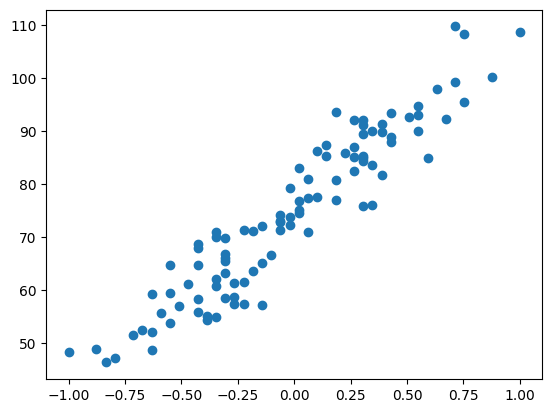

In [13]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(), x.max())
plt.scatter(x, y)

Epoch:    0/1000 loss_train: 2306.18456566
Epoch:  100/1000 loss_train: 15.64916949
Epoch:  200/1000 loss_train: 13.10136104
Epoch:  300/1000 loss_train: 13.04283334
Epoch:  400/1000 loss_train: 13.04148885
Epoch:  500/1000 loss_train: 13.04145797
Epoch:  600/1000 loss_train: 13.04145726
Epoch:  700/1000 loss_train: 13.04145724
Epoch:  800/1000 loss_train: 13.04145724
Epoch:  900/1000 loss_train: 13.04145724
Epoch: 1000/1000 loss_train: 13.04145724
Pesos:  [[33.60164744]]
Bias:  [[74.99636286]]


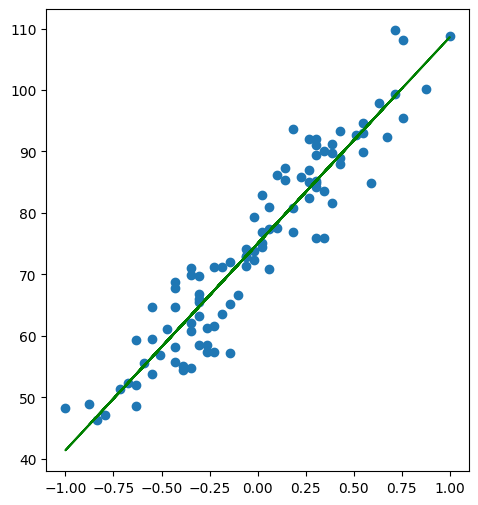

In [18]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=mse, learning_rate = 1e-1) # tentar com lr 1e-3
nn.layers.append(Layer(input_dim= input_dim, output_dim=output_dim, activation=linear))
#vamos treinar a rede
nn.fit(x, y, epochs=1000, verbose=100)
#vamos ver os pesos das ultimas camadas
print("Pesos: ", nn.layers[0].weights)
print("Bias: ", nn.layers[0].biases)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Linear Multivariada - Exercício de Regressão do Perceptron

In [20]:
data = np.loadtxt('notas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,:-1], data[:,-1].reshape(-1,1)
print(x.shape, y.shape)

(25, 4)
(25, 3) (25, 1)


In [24]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))
print(x.shape, y.shape)
#plt.scatter(x, y)

[-1. -1. -1.] [1. 1. 1.]
(25, 3) (25, 1)


In [25]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=mse, learning_rate = 1e-1) # tentar com lr 1e-3
nn.layers.append(Layer(input_dim= input_dim, output_dim=output_dim, activation=linear))
#vamos treinar a rede
nn.fit(x, y, epochs=2000, verbose=200)
#vamos ver os pesos das ultimas camadas
print("Pesos: ", nn.layers[0].weights)
print("Bias: ", nn.layers[0].biases)

Epoch:    0/2000 loss_train: 10133.70519441
Epoch:  200/2000 loss_train: 5.92584324
Epoch:  400/2000 loss_train: 3.73773493
Epoch:  600/2000 loss_train: 3.14394911
Epoch:  800/2000 loss_train: 2.96587511
Epoch: 1000/2000 loss_train: 2.90622308
Epoch: 1200/2000 loss_train: 2.88415489
Epoch: 1400/2000 loss_train: 2.87536753
Epoch: 1600/2000 loss_train: 2.87169982
Epoch: 1800/2000 loss_train: 2.87012658
Epoch: 2000/2000 loss_train: 2.86944158
Pesos:  [[ 8.90554186 13.9963003  26.18746579]]
Bias:  [[150.64011298]]


### Regressão Quadrática

(100, 1) (100, 1)


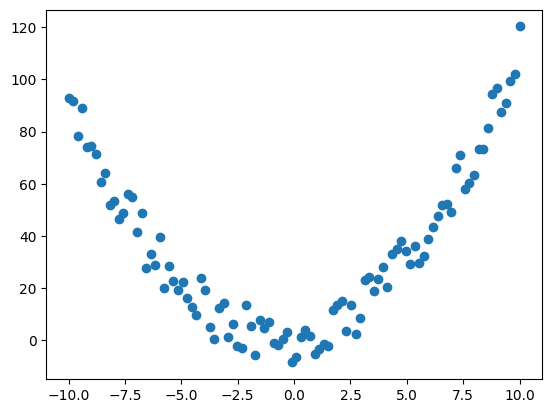

In [42]:
x, y = make_square(n_samples=100, x_min=-10, x_max=10, a=1, b=1, c=1, noise=10)

print(x.shape, y.shape)
plt.scatter(x, y)

In [54]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))
print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


Epoch:    0/5000 loss_train: 1003.86992225
Epoch:  200/5000 loss_train: 394.89063176
Epoch:  400/5000 loss_train: 210.71079724
Epoch:  600/5000 loss_train: 142.20232003
Epoch:  800/5000 loss_train: 104.93543903
Epoch: 1000/5000 loss_train: 81.76933028
Epoch: 1200/5000 loss_train: 66.43806363
Epoch: 1400/5000 loss_train: 55.86460058
Epoch: 1600/5000 loss_train: 48.26687033
Epoch: 1800/5000 loss_train: 42.60103020
Epoch: 2000/5000 loss_train: 38.24391134
Epoch: 2200/5000 loss_train: 34.80944368
Epoch: 2400/5000 loss_train: 32.05077493
Epoch: 2600/5000 loss_train: 29.80580637
Epoch: 2800/5000 loss_train: 27.96398858
Epoch: 3000/5000 loss_train: 26.44578558
Epoch: 3200/5000 loss_train: 25.19066851
Epoch: 3400/5000 loss_train: 24.15056587
Epoch: 3600/5000 loss_train: 23.28638076
Epoch: 3800/5000 loss_train: 22.56601917
Epoch: 4000/5000 loss_train: 21.96310320
Epoch: 4200/5000 loss_train: 21.45600145
Epoch: 4400/5000 loss_train: 21.02703333
Epoch: 4600/5000 loss_train: 20.66179547
Epoch: 480

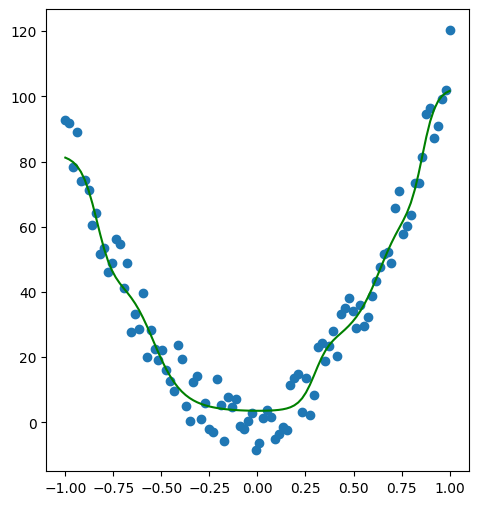

In [55]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
#modificar as funcoes de ativação
nn = NeuralNetwork(cost_func=mse, learning_rate = 1e-3) # tentar com lr 1e-3
nn.layers.append(Layer(input_dim= input_dim, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim= 10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim= 10, output_dim=output_dim, activation=linear))
#vamos treinar a rede
nn.fit(x, y, epochs=5000, verbose=200)
#vamos ver os pesos das ultimas camadas
print("Pesos: ", nn.layers[0].weights)
print("Bias: ", nn.layers[0].biases)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Cúbica

(100, 1) (100, 1)


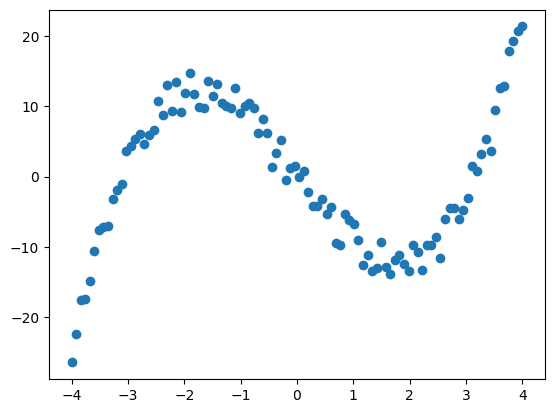

In [56]:
x, y = make_cubic(n_samples=100, x_min=-4, x_max=4, a=1, b=0, c=-10, d=0, noise=3)

print(x.shape, y.shape)
plt.scatter(x, y)

In [57]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


Epoch:    0/5000 loss_train: 53.92947692
Epoch:  200/5000 loss_train: 52.68357478
Epoch:  400/5000 loss_train: 52.48517285
Epoch:  600/5000 loss_train: 51.84284972
Epoch:  800/5000 loss_train: 50.64077376
Epoch: 1000/5000 loss_train: 48.57840889
Epoch: 1200/5000 loss_train: 45.69435998
Epoch: 1400/5000 loss_train: 42.55068391
Epoch: 1600/5000 loss_train: 39.50920350
Epoch: 1800/5000 loss_train: 36.45844187
Epoch: 2000/5000 loss_train: 33.16432387
Epoch: 2200/5000 loss_train: 29.45808960
Epoch: 2400/5000 loss_train: 25.05328909
Epoch: 2600/5000 loss_train: 19.92065627
Epoch: 2800/5000 loss_train: 15.28626013
Epoch: 3000/5000 loss_train: 11.79438107
Epoch: 3200/5000 loss_train: 9.34820921
Epoch: 3400/5000 loss_train: 7.62444771
Epoch: 3600/5000 loss_train: 6.37709935
Epoch: 3800/5000 loss_train: 5.45119450
Epoch: 4000/5000 loss_train: 4.75117498
Epoch: 4200/5000 loss_train: 4.21446124
Epoch: 4400/5000 loss_train: 3.79733269
Epoch: 4600/5000 loss_train: 3.46849063
Epoch: 4800/5000 loss_tr

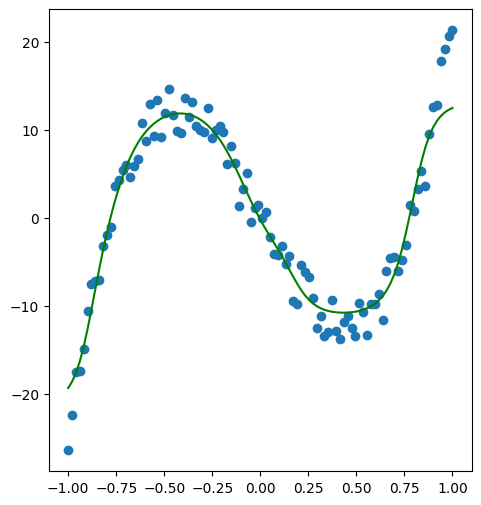

In [59]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!

#modificar as funcoes de ativação
nn = NeuralNetwork(cost_func=mse, learning_rate = 1e-3) # tentar com lr 1e-3
nn.layers.append(Layer(input_dim= input_dim, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim= 10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim= 10, output_dim=output_dim, activation=linear))
#vamos treinar a rede
nn.fit(x, y, epochs=5000, verbose=200)
#vamos ver os pesos das ultimas camadas
print("Pesos: ", nn.layers[0].weights)
print("Bias: ", nn.layers[0].biases)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Logarítimica

(100, 1) (100, 1)


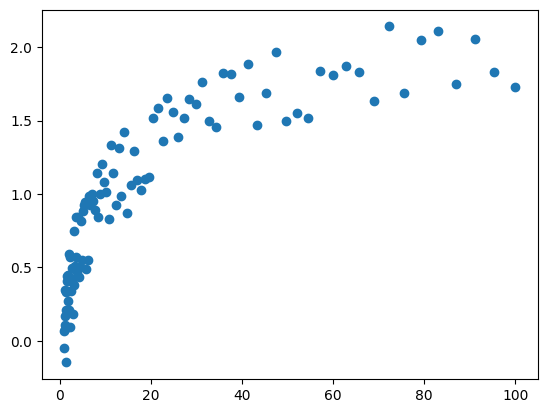

In [60]:
x, y = make_log10(n_samples=100, x_min=1, x_max=100, noise=0.3)

print(x.shape, y.shape)
plt.scatter(x, y)

In [61]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


Epoch:    0/5000 loss_train: 2.21233719
Epoch:  200/5000 loss_train: 0.70567732
Epoch:  400/5000 loss_train: 0.34894121
Epoch:  600/5000 loss_train: 0.20525005
Epoch:  800/5000 loss_train: 0.14910153
Epoch: 1000/5000 loss_train: 0.12617535
Epoch: 1200/5000 loss_train: 0.11560427
Epoch: 1400/5000 loss_train: 0.10970455
Epoch: 1600/5000 loss_train: 0.10563029
Epoch: 1800/5000 loss_train: 0.10229527
Epoch: 2000/5000 loss_train: 0.09927065
Epoch: 2200/5000 loss_train: 0.09638175
Epoch: 2400/5000 loss_train: 0.09355591
Epoch: 2600/5000 loss_train: 0.09076345
Epoch: 2800/5000 loss_train: 0.08799439
Epoch: 3000/5000 loss_train: 0.08524892
Epoch: 3200/5000 loss_train: 0.08253342
Epoch: 3400/5000 loss_train: 0.07985848
Epoch: 3600/5000 loss_train: 0.07723759
Epoch: 3800/5000 loss_train: 0.07468595
Epoch: 4000/5000 loss_train: 0.07221921
Epoch: 4200/5000 loss_train: 0.06985226
Epoch: 4400/5000 loss_train: 0.06759800
Epoch: 4600/5000 loss_train: 0.06546647
Epoch: 4800/5000 loss_train: 0.06346425


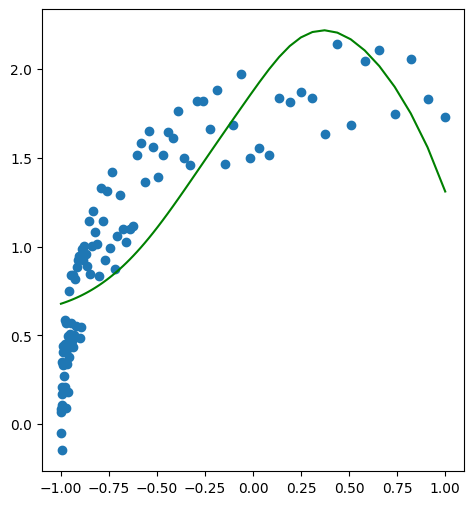

In [64]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
#modificar as funcoes de ativação
nn = NeuralNetwork(cost_func=mse, learning_rate = 1e-3) # tentar com lr 1e-3
nn.layers.append(Layer(input_dim= input_dim, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim= 10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim= 10, output_dim=output_dim, activation=linear))
#vamos treinar a rede
nn.fit(x, y, epochs=5000, verbose=200)
#vamos ver os pesos das ultimas camadas
print("Pesos: ", nn.layers[0].weights)
print("Bias: ", nn.layers[0].biases)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Exponencial

(100, 1) (100, 1)


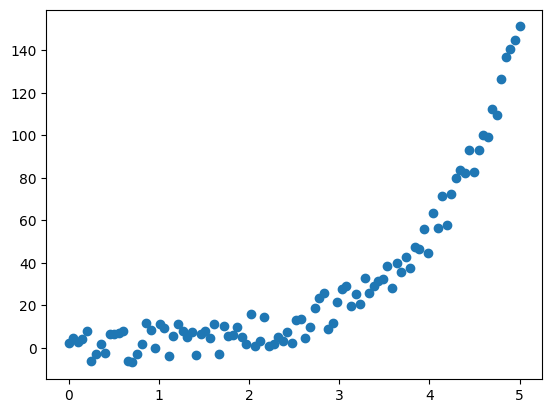

In [65]:
x, y = make_exp(n_samples=100, x_min=0, x_max=5, noise=10)

print(x.shape, y.shape)
plt.scatter(x, y)

In [66]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


Epoch:    0/5000 loss_train: 1137.21503633
Epoch:  200/5000 loss_train: 409.31312555
Epoch:  400/5000 loss_train: 232.59555138
Epoch:  600/5000 loss_train: 149.00854335
Epoch:  800/5000 loss_train: 104.32098323
Epoch: 1000/5000 loss_train: 78.93888473
Epoch: 1200/5000 loss_train: 63.25057898
Epoch: 1400/5000 loss_train: 52.78687330
Epoch: 1600/5000 loss_train: 45.31487724
Epoch: 1800/5000 loss_train: 39.61435302
Epoch: 2000/5000 loss_train: 35.14549074
Epoch: 2200/5000 loss_train: 31.60340523
Epoch: 2400/5000 loss_train: 28.76708401
Epoch: 2600/5000 loss_train: 26.47428825
Epoch: 2800/5000 loss_train: 24.60095977
Epoch: 3000/5000 loss_train: 23.05191141
Epoch: 3200/5000 loss_train: 21.75501193
Epoch: 3400/5000 loss_train: 20.65662301
Epoch: 3600/5000 loss_train: 19.71745893
Epoch: 3800/5000 loss_train: 18.90869184
Epoch: 4000/5000 loss_train: 18.20864248
Epoch: 4200/5000 loss_train: 17.60037487
Epoch: 4400/5000 loss_train: 17.07017717
Epoch: 4600/5000 loss_train: 16.60667696
Epoch: 480

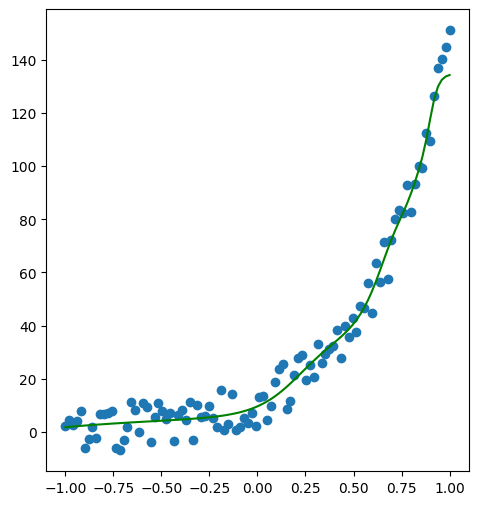

In [67]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
#modificar as funcoes de ativação
nn = NeuralNetwork(cost_func=mse, learning_rate = 1e-3) # tentar com lr 1e-3
nn.layers.append(Layer(input_dim= input_dim, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim= 10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim= 10, output_dim=output_dim, activation=linear))
#vamos treinar a rede
nn.fit(x, y, epochs=5000, verbose=200)
#vamos ver os pesos das ultimas camadas
print("Pesos: ", nn.layers[0].weights)
print("Bias: ", nn.layers[0].biases)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

## Classificação Binária

### Porta AND/OR

(4, 2) (4, 1)


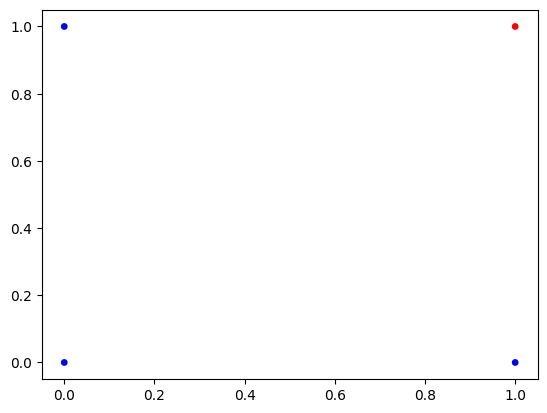

In [68]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 0, 0, 1]).reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

Epoch:    0/2000 loss_train: 1.28352165
Epoch:  200/2000 loss_train: 0.05461135
Epoch:  400/2000 loss_train: 0.04151227
Epoch:  600/2000 loss_train: 0.03554852
Epoch:  800/2000 loss_train: 0.03190832
Epoch: 1000/2000 loss_train: 0.02937312
Epoch: 1200/2000 loss_train: 0.02746822
Epoch: 1400/2000 loss_train: 0.02596425
Epoch: 1600/2000 loss_train: 0.02473469
Epoch: 1800/2000 loss_train: 0.02370308
Epoch: 2000/2000 loss_train: 0.02282006
Pesos:  [[10.0162955  10.01629551]]
Bias:  [[-17.67387441]]
Predições:
[[2.11024977e-08]
 [4.72226773e-04]
 [4.72226771e-04]
 [9.13624580e-01]]
Acurácia: 100.00%


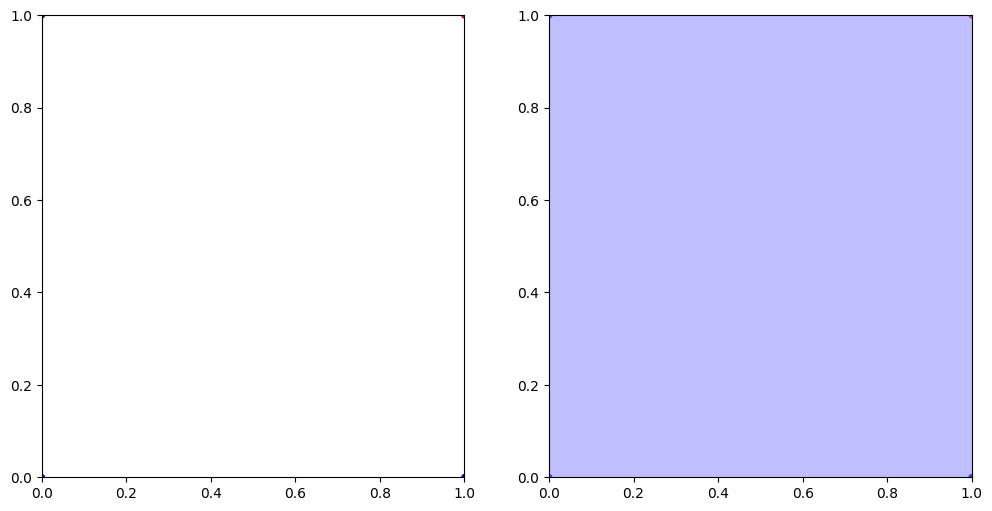

In [71]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
#modificar as funcoes de ativação
nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate = 1) # tentar com lr 1e-3
nn.layers.append(Layer(input_dim= input_dim, output_dim=output_dim, activation=sigmoid)) # se usar a linear a fncao de custo deve ser sigmoid cross entropy
#vamos treinar a rede
nn.fit(x, y, epochs=2000, verbose=200)
#vamos ver os pesos das ultimas camadas
print("Pesos: ", nn.layers[0].weights)
print("Bias: ", nn.layers[0].biases)
y_pred = nn.predict(x)
print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5))) # aqui temos nossos thresHold

plot.classification_predictions(x, y, is_binary=True, nn=nn, cmap='bwr')

### Porta XOR

(4, 2) (4, 1)


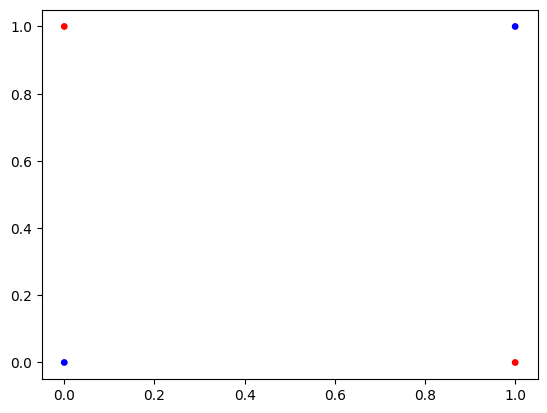

In [114]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0]).reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

Epoch:    0/2000 loss_train: 0.80687535
Epoch:  200/2000 loss_train: 0.55427387
Epoch:  400/2000 loss_train: 0.14143601
Epoch:  600/2000 loss_train: 0.05927450
Epoch:  800/2000 loss_train: 0.03638868
Epoch: 1000/2000 loss_train: 0.02603831
Epoch: 1200/2000 loss_train: 0.02020353
Epoch: 1400/2000 loss_train: 0.01647647
Epoch: 1600/2000 loss_train: 0.01389637
Epoch: 1800/2000 loss_train: 0.01200726
Epoch: 2000/2000 loss_train: 0.01056575
Predições:
[[0.0093282 ]
 [0.98782992]
 [0.98771137]
 [0.00824731]]
Acurácia: 100.00%


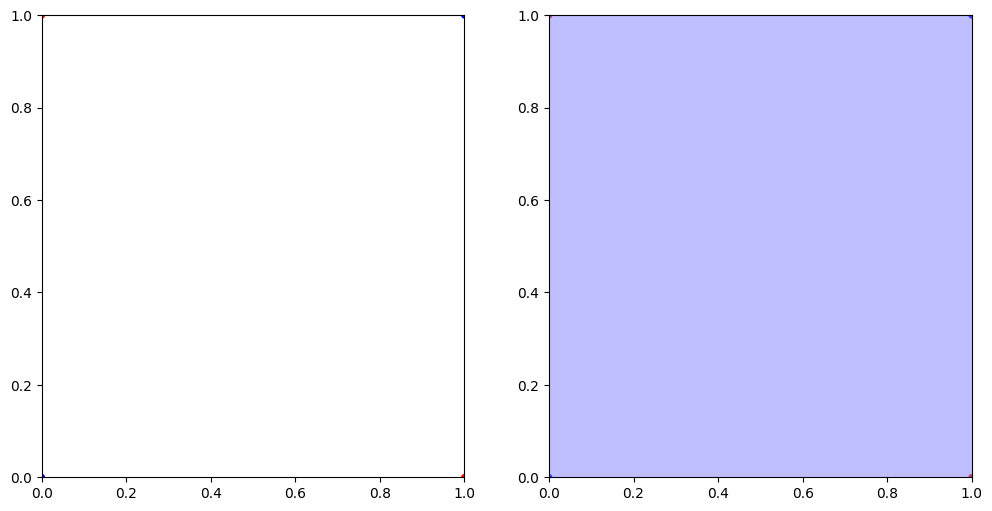

In [115]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate = 1) # tentar com lr 1e-3
nn.layers.append(Layer(input_dim= input_dim, output_dim=2, activation=sigmoid)) 
nn.layers.append(Layer(input_dim= 2, output_dim=output_dim, activation=sigmoid)) # se usar a linear a fncao de custo deve ser sigmoid cross entropy
#vamos treinar a rede
nn.fit(x, y, epochs=2000, verbose=200)
y_pred = nn.predict(x)
print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, cmap='bwr')

### 2 Clusters

(100, 2) (100, 1)


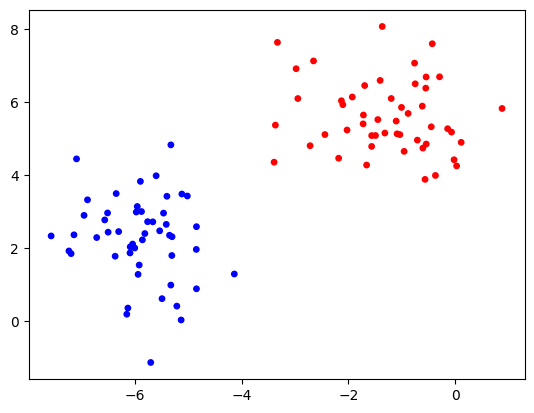

In [112]:
x, y = make_blobs(n_samples=100, n_features=2, centers=2, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

Epoch:    0/5000 loss_train: 7.23783657
Epoch: 1000/5000 loss_train: 0.74885162
Epoch: 2000/5000 loss_train: 0.16742023
Epoch: 3000/5000 loss_train: 0.09748988
Epoch: 4000/5000 loss_train: 0.07095042
Epoch: 5000/5000 loss_train: 0.05682935
Acurácia: 100.00%


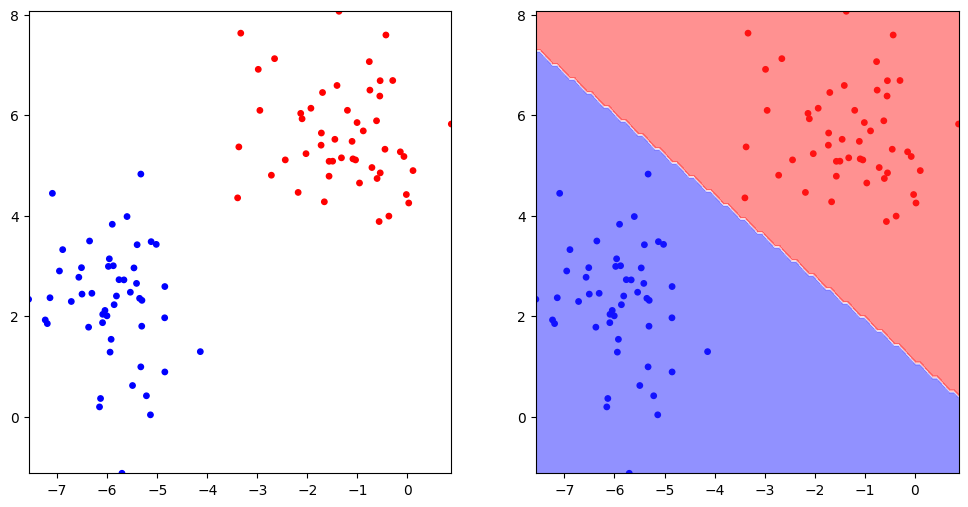

In [113]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate = 1e-3) # tentar com lr 1
nn.layers.append(Layer(input_dim= input_dim, output_dim=output_dim, activation=linear))
#vamos treinar a rede
nn.fit(x, y, epochs=5000, verbose=1000)
y_pred = nn.predict(x)

threshold = 0 if nn.layers[-1].activation == linear else 0.5
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred >= threshold)))
plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=threshold, cmap='bwr')

### 4 Clusters

(500, 2) (500, 1)


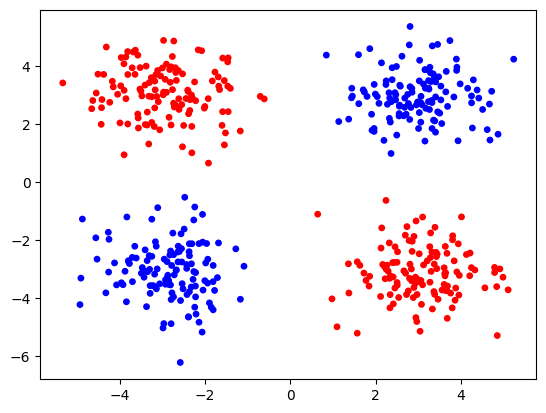

In [98]:
x, y = make_blobs(n_samples=500, n_features=2, cluster_std=0.9, centers=[(-3, -3), (3, 3), (-3, 3), (3, -3)], random_state=1234)
y = y.reshape(-1, 1)
y = np.where(y >= 2, 1, 0)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

Epoch:    0/2000 loss_train: 0.66006516
Epoch:  100/2000 loss_train: 0.19481462
Epoch:  200/2000 loss_train: 0.06823062
Epoch:  300/2000 loss_train: 0.04372622
Epoch:  400/2000 loss_train: 0.03400686
Epoch:  500/2000 loss_train: 0.02868657
Epoch:  600/2000 loss_train: 0.02526569
Epoch:  700/2000 loss_train: 0.02286159
Epoch:  800/2000 loss_train: 0.02105014
Epoch:  900/2000 loss_train: 0.01961780
Epoch: 1000/2000 loss_train: 0.01849838
Epoch: 1100/2000 loss_train: 0.01757422
Epoch: 1200/2000 loss_train: 0.01678451
Epoch: 1300/2000 loss_train: 0.01609546
Epoch: 1400/2000 loss_train: 0.01547898
Epoch: 1500/2000 loss_train: 0.01491511
Epoch: 1600/2000 loss_train: 0.01439114
Epoch: 1700/2000 loss_train: 0.01390608
Epoch: 1800/2000 loss_train: 0.01344554
Epoch: 1900/2000 loss_train: 0.01300389
Epoch: 2000/2000 loss_train: 0.01257451
Acurácia: 99.80%


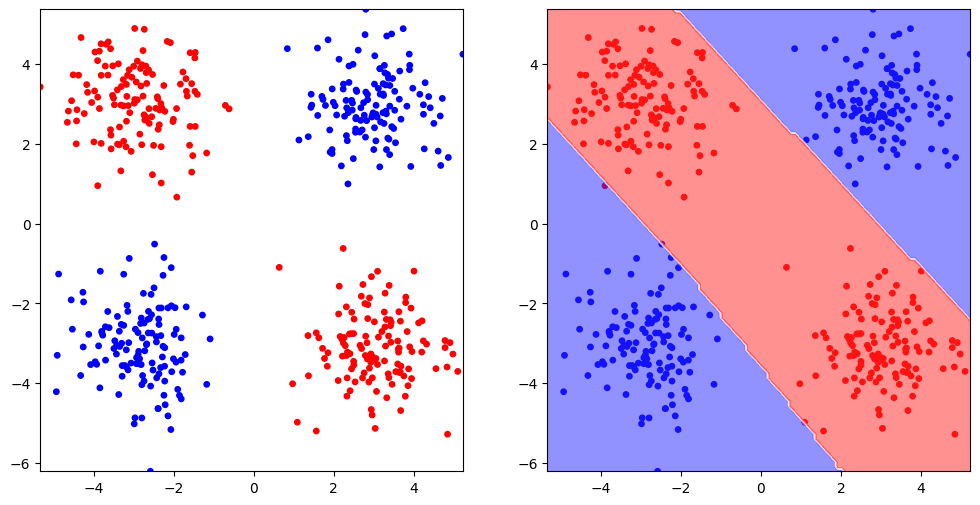

In [111]:
input_dim, output_dim = x.shape[1], y.shape[1]


# insira sua rede aqui!
nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate = 1e-1) # tentar com lr 1
nn.layers.append(Layer(input_dim= input_dim, output_dim=4, activation=relu))
nn.layers.append(Layer(input_dim= 4, output_dim=4, activation=relu))
nn.layers.append(Layer(input_dim= 4, output_dim=output_dim, activation=sigmoid))
#vamos treinar a rede
nn.fit(x, y, epochs=2000, verbose=100)
y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Círculos

(500, 2) (500, 1)


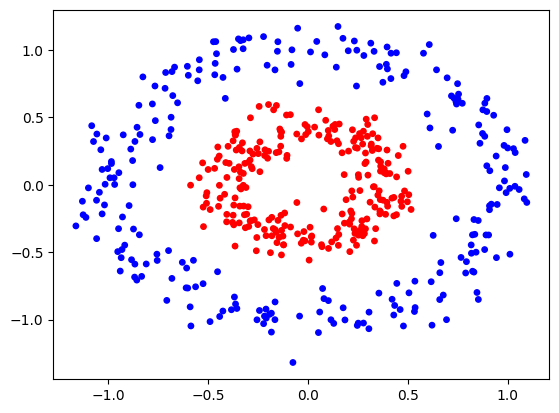

In [116]:
x, y = make_circles(n_samples=500, noise=0.1, factor=0.4, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

Epoch:    0/2000 loss_train: 0.60138205
Epoch:  100/2000 loss_train: 0.07401287
Epoch:  200/2000 loss_train: 0.04331849
Epoch:  300/2000 loss_train: 0.03066358
Epoch:  400/2000 loss_train: 0.02370100
Epoch:  500/2000 loss_train: 0.01932053
Epoch:  600/2000 loss_train: 0.01620148
Epoch:  700/2000 loss_train: 0.01389879
Epoch:  800/2000 loss_train: 0.01220056
Epoch:  900/2000 loss_train: 0.01080891
Epoch: 1000/2000 loss_train: 0.00966897
Epoch: 1100/2000 loss_train: 0.00876486
Epoch: 1200/2000 loss_train: 0.00801699
Epoch: 1300/2000 loss_train: 0.00738550
Epoch: 1400/2000 loss_train: 0.00684454
Epoch: 1500/2000 loss_train: 0.00637445
Epoch: 1600/2000 loss_train: 0.00596387
Epoch: 1700/2000 loss_train: 0.00560181
Epoch: 1800/2000 loss_train: 0.00527882
Epoch: 1900/2000 loss_train: 0.00498881
Epoch: 2000/2000 loss_train: 0.00472784
Acurácia: 100.00%


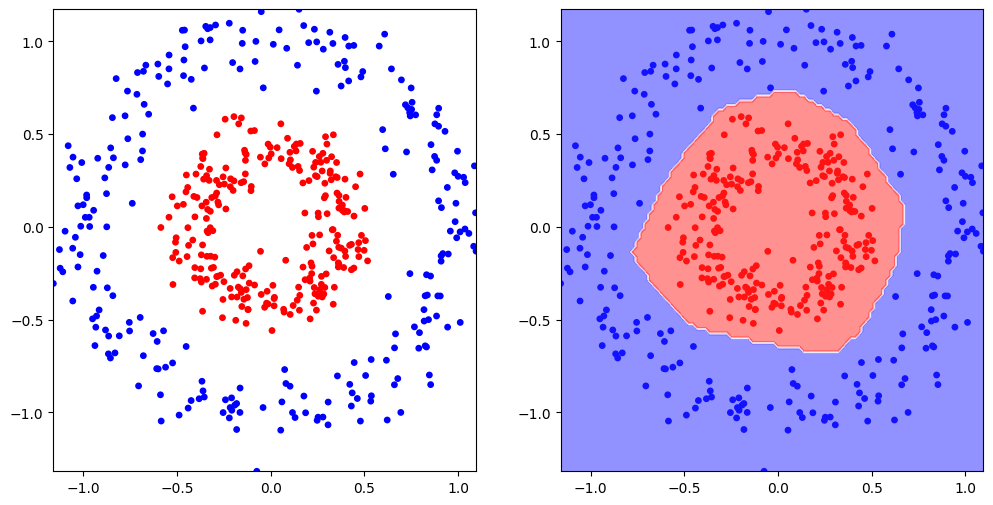

In [118]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate = 1e-1) # tentar com lr 1
nn.layers.append(Layer(input_dim= input_dim, output_dim=12, activation=relu))
nn.layers.append(Layer(input_dim= 12, output_dim=12, activation=relu))
nn.layers.append(Layer(input_dim= 12, output_dim=output_dim, activation=sigmoid))
#vamos treinar a rede
nn.fit(x, y, epochs=2000, verbose=100)
y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Moons

(200, 2) (200, 1)


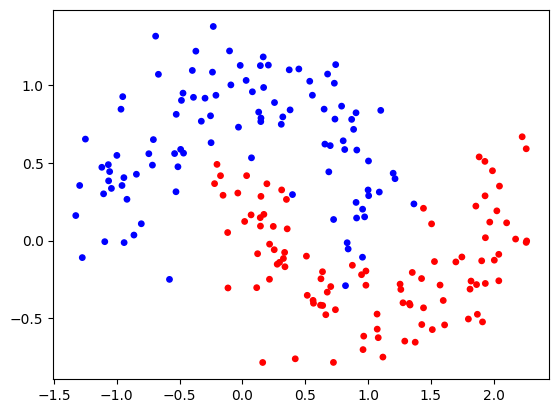

In [119]:
x, y = make_moons(200, noise=0.20)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

Epoch:    0/2000 loss_train: 0.61282630
Epoch:  100/2000 loss_train: 0.10332128
Epoch:  200/2000 loss_train: 0.07489659
Epoch:  300/2000 loss_train: 0.06060184
Epoch:  400/2000 loss_train: 0.05235741
Epoch:  500/2000 loss_train: 0.04780845
Epoch:  600/2000 loss_train: 0.04458727
Epoch:  700/2000 loss_train: 0.04209888
Epoch:  800/2000 loss_train: 0.04007075
Epoch:  900/2000 loss_train: 0.03838295
Epoch: 1000/2000 loss_train: 0.03689648
Epoch: 1100/2000 loss_train: 0.03545540
Epoch: 1200/2000 loss_train: 0.03378374
Epoch: 1300/2000 loss_train: 0.03258816
Epoch: 1400/2000 loss_train: 0.03159758
Epoch: 1500/2000 loss_train: 0.03067792
Epoch: 1600/2000 loss_train: 0.02990478
Epoch: 1700/2000 loss_train: 0.02912670
Epoch: 1800/2000 loss_train: 0.02836036
Epoch: 1900/2000 loss_train: 0.02770136
Epoch: 2000/2000 loss_train: 0.02704540
Acurácia: 99.50%


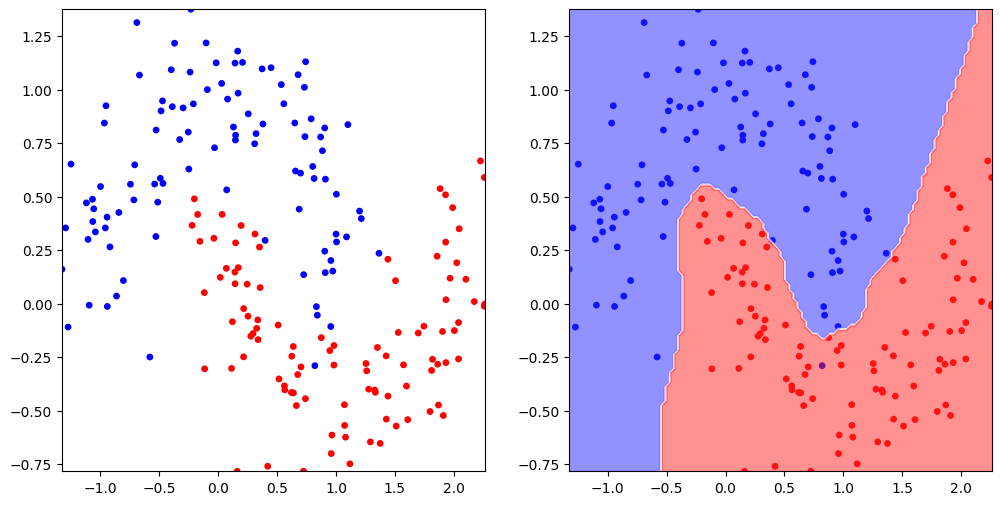

In [121]:
input_dim, output_dim = x.shape[1], y.shape[1]


# insira sua rede aqui!
nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate = 1e-1) # tentar com lr 1
nn.layers.append(Layer(input_dim= input_dim, output_dim=12, activation=relu))
nn.layers.append(Layer(input_dim= 12, output_dim=12, activation=relu))
nn.layers.append(Layer(input_dim= 12, output_dim=output_dim, activation=sigmoid))
#vamos treinar a rede
nn.fit(x, y, epochs=2000, verbose=100)
y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Espiral

(200, 2) (200, 1)


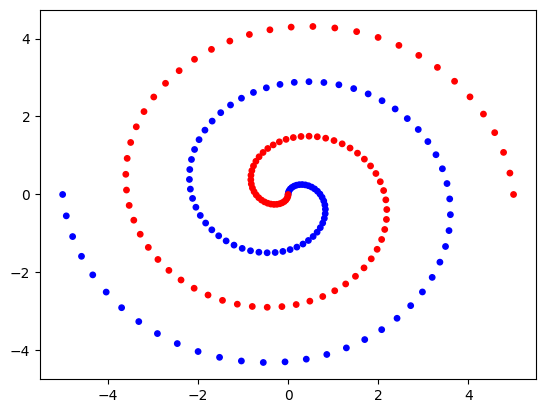

In [122]:
x, y = make_spiral(n_samples=100, n_class=2, radius=5, laps=1.75)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

Epoch:    0/10000 loss_train: 1.33786642
Epoch: 1000/10000 loss_train: 0.13727503
Epoch: 2000/10000 loss_train: 0.04405825
Epoch: 3000/10000 loss_train: 0.02457728
Epoch: 4000/10000 loss_train: 0.01816569
Epoch: 5000/10000 loss_train: 0.01500150
Epoch: 6000/10000 loss_train: 0.01310753
Epoch: 7000/10000 loss_train: 0.01187446
Epoch: 8000/10000 loss_train: 0.01102092
Epoch: 9000/10000 loss_train: 0.01040100
Epoch: 10000/10000 loss_train: 0.00993325
Acurácia: 99.50%


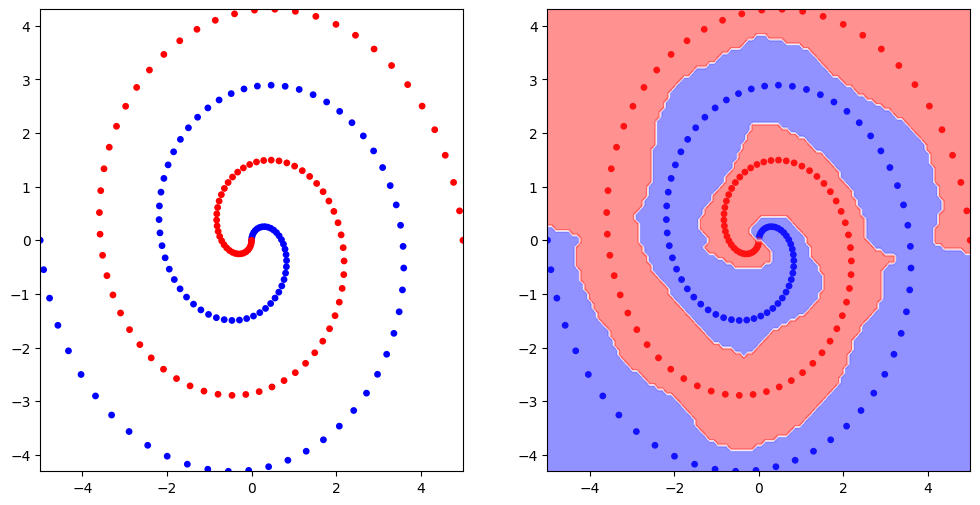

In [124]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate = 1e-1) # tentar com lr 1
nn.layers.append(Layer(input_dim= input_dim, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim= 20, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim= 20, output_dim=output_dim, activation=sigmoid))
#vamos treinar a rede
nn.fit(x, y, epochs=10000, verbose=1000)
y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

## Classificação Multiclasse

### 3 Clusters Multiclasse

(300, 2) (300, 1)


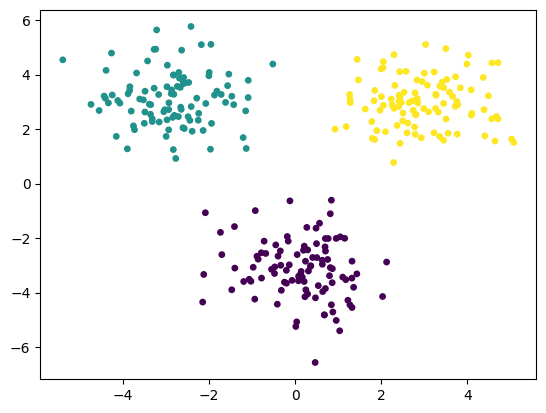

In [125]:
x, y = make_blobs(n_samples=300, n_features=2, centers=[(0, -3), (-3, 3), (3, 3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [126]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::60])

[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch:    0/1000 loss_train: 1.81660679
Epoch:  100/1000 loss_train: 0.14546200
Epoch:  200/1000 loss_train: 0.06503709
Epoch:  300/1000 loss_train: 0.03919552
Epoch:  400/1000 loss_train: 0.02740271
Epoch:  500/1000 loss_train: 0.02082646
Epoch:  600/1000 loss_train: 0.01671919
Epoch:  700/1000 loss_train: 0.01393837
Epoch:  800/1000 loss_train: 0.01193346
Epoch:  900/1000 loss_train: 0.01042077
Epoch: 1000/1000 loss_train: 0.00924194
Acurácia: 100.00%


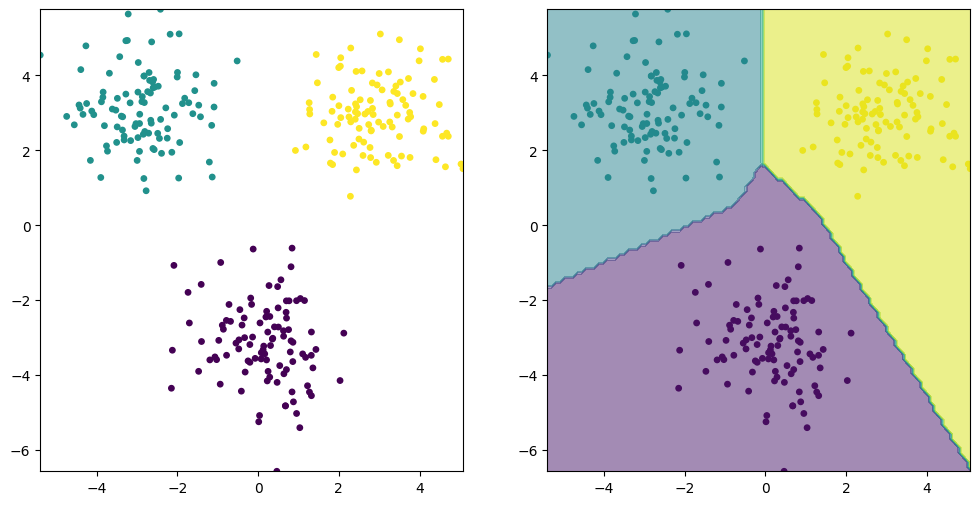

In [128]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate = 1e-1) # tentar com lr 1
nn.layers.append(Layer(input_dim= input_dim, output_dim=2, activation=relu))
nn.layers.append(Layer(input_dim= 2, output_dim=output_dim, activation=linear))
#vamos treinar a rede
nn.fit(x, y_onehot, epochs=1000, verbose=100)
    
y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### 4 Clusters Multiclasse

(400, 2) (400, 1)


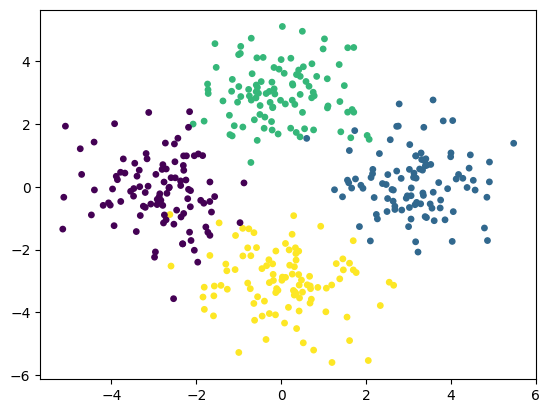

In [129]:
x, y = make_blobs(n_samples=400, n_features=2, centers=[(-3, 0), (3, 0), (0, 3), (0, -3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [130]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::70])

[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch:    0/1000 loss_train: 4.55022306
Epoch:  100/1000 loss_train: 0.30392239
Epoch:  200/1000 loss_train: 0.19667794
Epoch:  300/1000 loss_train: 0.15406773
Epoch:  400/1000 loss_train: 0.13060986
Epoch:  500/1000 loss_train: 0.11718640
Epoch:  600/1000 loss_train: 0.10838829
Epoch:  700/1000 loss_train: 0.10210025
Epoch:  800/1000 loss_train: 0.09744367
Epoch:  900/1000 loss_train: 0.09382070
Epoch: 1000/1000 loss_train: 0.09089819
Acurácia: 96.50%


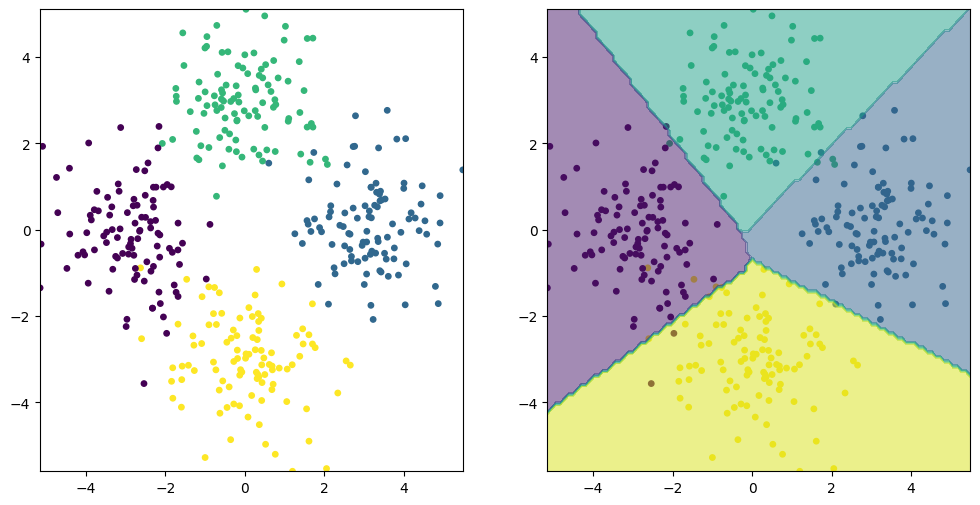

In [133]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate = 1e-1) # tentar com lr 1
nn.layers.append(Layer(input_dim= input_dim, output_dim=3, activation=relu))
nn.layers.append(Layer(input_dim= 3, output_dim=output_dim, activation=linear))
#vamos treinar a rede
nn.fit(x, y_onehot, epochs=1000, verbose=100)
y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### Espiral - 5 Classes

(500, 2) (500, 1)


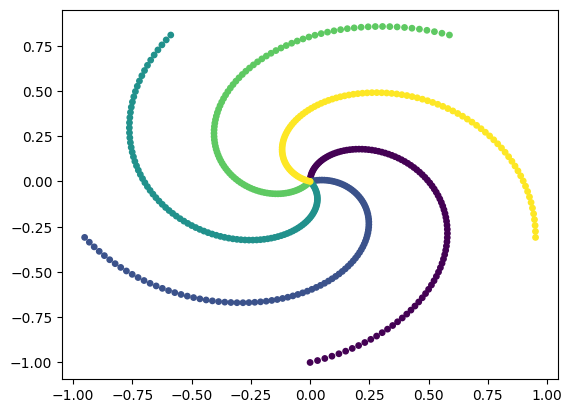

In [134]:
x, y = make_spiral(n_samples=100, n_class=5, radius=1, laps=0.5)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [135]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::100])

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch:    0/1000 loss_train: 3.37533226
Epoch:  100/1000 loss_train: 0.87181252
Epoch:  200/1000 loss_train: 0.71079455
Epoch:  300/1000 loss_train: 0.58318197
Epoch:  400/1000 loss_train: 0.48128258
Epoch:  500/1000 loss_train: 0.40161040
Epoch:  600/1000 loss_train: 0.34180396
Epoch:  700/1000 loss_train: 0.29796295
Epoch:  800/1000 loss_train: 0.26489210
Epoch:  900/1000 loss_train: 0.23852214
Epoch: 1000/1000 loss_train: 0.21687072
Acurácia: 95.20%


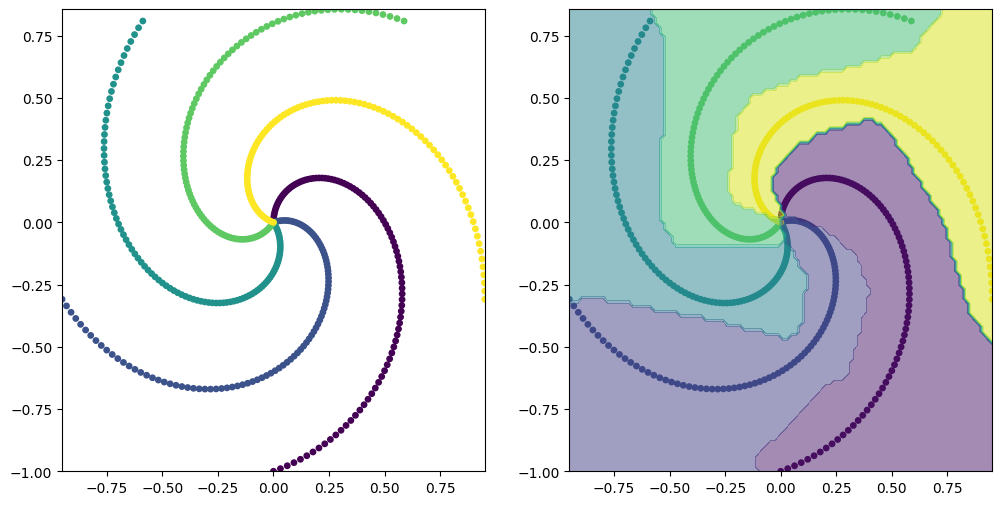

In [137]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate = 1e-1) # tentar com lr 1
nn.layers.append(Layer(input_dim= input_dim, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim= 10, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim= 10, output_dim=output_dim, activation=linear))
#vamos treinar a rede
nn.fit(x, y_onehot, epochs=1000, verbose=100)
y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### Make Classification - 4 Classes

(100, 2) (100, 1)


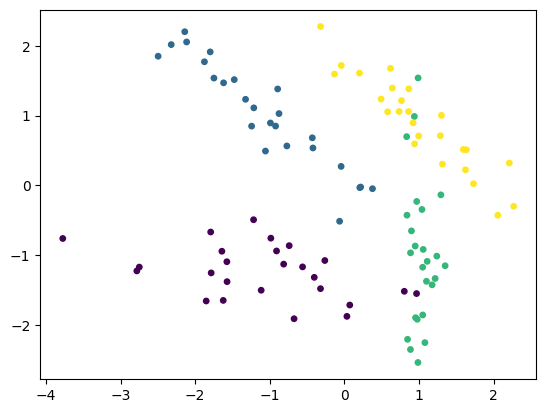

In [139]:
x, y = make_classification(n_samples=100, n_classes=4, n_features=2, n_clusters_per_class=1, n_redundant=0, n_repeated=0, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [140]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::10])

[[0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch:    0/1000 loss_train: 3.34786729
Epoch:  100/1000 loss_train: 0.27406952
Epoch:  200/1000 loss_train: 0.21813538
Epoch:  300/1000 loss_train: 0.19491113
Epoch:  400/1000 loss_train: 0.18446350
Epoch:  500/1000 loss_train: 0.17733648
Epoch:  600/1000 loss_train: 0.17175503
Epoch:  700/1000 loss_train: 0.16721523
Epoch:  800/1000 loss_train: 0.16338026
Epoch:  900/1000 loss_train: 0.16011396
Epoch: 1000/1000 loss_train: 0.15714064
Acurácia: 95.00%


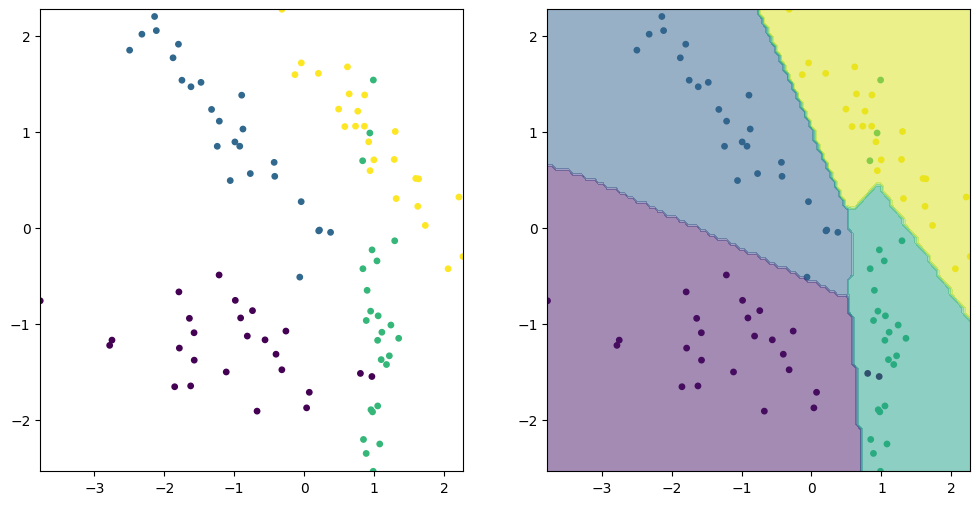

In [142]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate = 1e-1) # tentar com lr 1
nn.layers.append(Layer(input_dim= input_dim, output_dim=5, activation=relu))
nn.layers.append(Layer(input_dim= 5, output_dim=output_dim, activation=linear))
#vamos treinar a rede
nn.fit(x, y_onehot, epochs=1000, verbose=100)
y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### Iris Dataset

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']
(150, 2) (150, 1)


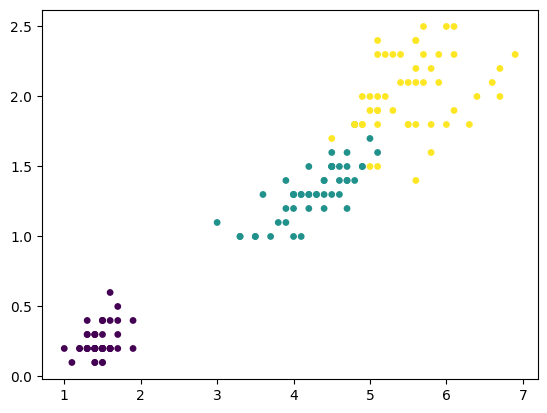

In [143]:
data = load_iris()
x, y = data.data[:, 2:], data.target.reshape(-1,1)

print(data.feature_names)
print(data.target_names)
print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [144]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::20])

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch:    0/1000 loss_train: 4.34559326
Epoch:  100/1000 loss_train: 0.47941698
Epoch:  200/1000 loss_train: 0.37772044
Epoch:  300/1000 loss_train: 0.31779366
Epoch:  400/1000 loss_train: 0.27112601
Epoch:  500/1000 loss_train: 0.23263719
Epoch:  600/1000 loss_train: 0.20244684
Epoch:  700/1000 loss_train: 0.17959228
Epoch:  800/1000 loss_train: 0.16239674
Epoch:  900/1000 loss_train: 0.14930125
Epoch: 1000/1000 loss_train: 0.13913344
Acurácia: 95.33%


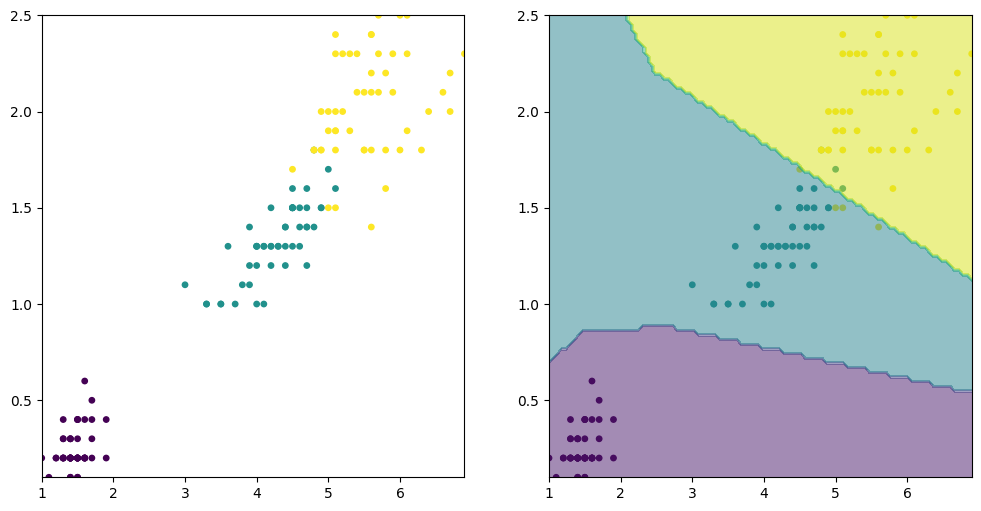

In [147]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# insira sua rede aqui!
# insira sua rede aqui!
nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate = 1e-1) # tentar com lr 1
nn.layers.append(Layer(input_dim= input_dim, output_dim=5, activation=relu))
nn.layers.append(Layer(input_dim= 5, output_dim=output_dim, activation=linear))
#vamos treinar a rede
nn.fit(x, y_onehot, epochs=1000, verbose=100)
y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

# [Link para o Questionário](https://docs.google.com/forms/d/e/1FAIpQLSf1B3JKsPPPc1oYD_3FyX4UvNLpcXnTW2I177A_WE0_B56Elw/viewform?usp=sf_link)

# Referências

- [Tensorflow Playground](http://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.94880&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

- [Linear Classification](http://cs231n.github.io/linear-classify/)

__Regularization__:
- [Implementing Neural Network L1 Regularization](https://jamesmccaffrey.wordpress.com/2017/06/27/implementing-neural-network-l1-regularization/)
- [Implementing Neural Network L2 Regularization](https://jamesmccaffrey.wordpress.com/2017/06/29/implementing-neural-network-l2-regularization/)
- [Neural Network L2 Regularization Using Python](https://visualstudiomagazine.com/articles/2017/09/01/neural-network-l2.aspx)

__Momentum__:
- [Neural Network Momentum Using Python](https://visualstudiomagazine.com/articles/2017/08/01/neural-network-momentum.aspx)
- [Beyond SGD: Gradient Descent with Momentum and Adaptive Learning Rate](https://wiseodd.github.io/techblog/2016/06/22/nn-optimization/)

__Learning Rate Decay__:
- [Using Learning Rate Schedules for Deep Learning Models in Python with Keras](https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/)
- [Learning Rate Schedules and Adaptive Learning Rate Methods for Deep Learning](https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1)
- [Tensorflow Exponential Decay Documentation](https://www.tensorflow.org/api_docs/python/tf/train/exponential_decay)

__Batch Normalization__:
- [Understanding the backward pass through Batch Normalization Layer](https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html)
- [Deriving the Gradient for the Backward Pass of Batch Normalization](https://kevinzakka.github.io/2016/09/14/batch_normalization/)
- [Implementing BatchNorm in Neural Net](https://wiseodd.github.io/techblog/2016/07/04/batchnorm/)
- [What does the gradient flowing through batch normalization looks like ?](http://cthorey.github.io./backpropagation/)
- [GRADIENTS, BATCH NORMALIZATION AND LAYER NORMALIZATION](https://theneuralperspective.com/2016/10/27/gradient-topics/)

__Gradient Checking__:
- [cs231n](https://github.com/cs231n/cs231n.github.io/blob/master/neural-networks-3.md#gradcheck)
- [Gradient checking and advanced optimization](http://ufldl.stanford.edu/wiki/index.php/Gradient_checking_and_advanced_optimization)
- [BatchNormalization fails gradient checking](https://github.com/torch/nn/issues/744)